In [1]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
import multiprocessing as mp

In [80]:
# jupyter notebook settings for debugging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM_per_atom, get_stats_EAM_per_box

In [3]:
# Define locations of relevant datasets

target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

# MD trajectories
datasets_MD = ['bcc_npt_langevin_300K',
            'fcc_npt_langevin_300K',
            'vac_npt_langevin_2000K',
            'i110_npt_langevin_2000K',
            'i111_npt_langevin_2000K',
            'screw_111_npt_langevin_2000K',
            'bcc_npt_langevin_3700K',
            'liq_3700K',
            'liq_5000K']

# 0K relaxed structures
datasets_0k = ['bcc_0k',
               'fcc_0k',
               'vac_0k',
               'i110_0k',
               'i111_0k',
               'screw_111_0k']

# equations of state for BCC and FCC lattices
scales = ['v0','v0.8','v0.9','v1.1','v1.2','v1.3','v1.4','v1.5']

datasets_eos_bcc = ['eq_st_bcc/'+s for s in scales]

datasets_eos_fcc = ['eq_st_fcc/'+s for s in scales]

# defined dataset directories relative to the current directory (/notebooks)
trajdirs_MD = [target_raw + '/' + dataset for dataset in datasets_MD]
trajdirs_0k = [target_raw + '/' + dataset for dataset in datasets_0k]
trajdirs_eos_bcc = [target_raw + '/' + dataset for dataset in datasets_eos_bcc]
trajdirs_eos_fcc = [target_raw + '/' + dataset for dataset in datasets_eos_fcc]

In [4]:
%%time

# set up a multiprocessing pool
pool = mp.Pool()

# read MD trajectories in parallel
output_data = pool.map(read_vasp, trajdirs_MD)
trajectories_MD = dict(zip(datasets_MD, output_data))
print('Done with MD')

# read 0K configurations in parallel
output_data = pool.map(read_vasp, trajdirs_0k)
trajectories_0k = dict(zip(datasets_0k, output_data))
print('Done with 0k')

# read BCC EOS in parallel
output_data = pool.map(read_vasp, trajdirs_eos_bcc)
trajectories_eos_bcc = dict(zip(datasets_eos_bcc, output_data))
print('Done with BCC EOS')

# read BCC EOS in parallel
output_data = pool.map(read_vasp, trajdirs_eos_fcc)
trajectories_eos_fcc = dict(zip(datasets_eos_fcc, output_data))
print('Done with FCC EOS')

Done with MD
Done with 0k
Done with BCC EOS
Done with FCC EOS
CPU times: user 488 ms, sys: 301 ms, total: 790 ms
Wall time: 5min


Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "//anaconda/envs/py36/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "//anaconda/envs/py36/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "//anaconda/envs/py36/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "//anaconda/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "//anaconda/envs/py36/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "//anaconda/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "//anaconda/envs/py36/lib/python3.6/m

In [5]:
#trajectories_MD = trajectories

In [6]:
#%%time
## read MD trajectories
#trajectories_old = {}
#for name, traj_path in zip(datasets_MD, trajdirs_MD):
#    trajectories_old[name] = read_vasp(traj_path)

## test if serial and multiprocessing give the same results
#import dictdiffer
#assert list(dictdiffer.diff(trajectories, trajectories_old)) == [], "There are differences between serial and parallel reading of VASP files"

In [59]:
# Convert MD trajectory dicts to objects
trjs_MD = {}
for k, trj in trajectories_MD.items():
    trjs_MD[k] = Trajectory(trj, inplace=False)
    
# Convert MD trajectory 0K configs to objects
trjs_0k = {}
for k, trj in trajectories_0k.items():
    trjs_0k[k] = Trajectory(trj, inplace=False)[-1]

# Convert MD trajectory bcc eos configs to objects
trjs_eos_bcc = {}
for k, trj in trajectories_eos_bcc.items():
    trjs_eos_bcc[k] = Trajectory(trj, inplace=False)[-1]
    
# Convert MD trajectory bcc eos configs to objects
trjs_eos_fcc = {}
for k, trj in trajectories_eos_fcc.items():
    trjs_eos_fcc[k] = Trajectory(trj, inplace=False)[-1]

In [60]:
trjs_0k['bcc_0k']['energy']

[-1656.3257]

In [61]:
#trjs_MD['bcc_npt_langevin_300K']['energy']

In [62]:
# Join relaxed configurations into pseudo-trajectories

# join 0 K configurations into a pseudo-trajectory
traj_0k = copy.deepcopy(trjs_0k['bcc_0k'])
for k, trj in trjs_0k.items():
    if 'bcc_0k' not in k:
        traj_0k.append(trj)

# join eos bcc configurations into a pseudo-trajectory
traj_eos_bcc = copy.deepcopy(trjs_eos_bcc['eq_st_bcc/v0'])
for k, trj in trjs_eos_bcc.items():
    if k != 'eq_st_bcc/v0':
        traj_eos_bcc.append(trj)

# join eos fcc configurations into a pseudo-trajectory
traj_eos_fcc = copy.deepcopy(trjs_eos_fcc['eq_st_fcc/v0'])
for k, trj in trjs_eos_fcc.items():
    if k != 'eq_st_fcc/v0':
        traj_eos_fcc.append(trj)

In [63]:
# Create a dictionary of trajectories

trjs = {}
trjs.update(trjs_MD)
trjs['relax'] = traj_0k
trjs['eos_bcc'] = traj_eos_bcc
trjs['eos_fcc'] = traj_eos_fcc

In [64]:
len(trjs['eos_bcc']['energy'])

8

In [65]:
# shift zero of energy to by subtracting intra-atomic contributions (energy of an isolated atom)

u_total = traj_0k['energy'][0]/len(traj_0k['xyz'][0]) # total energy of a BCC lattice from DFT
u_lattice = -8.9 # experimental lattice energy of a BCC lattice
u_intra = u_total - u_lattice # internal energy per atom (to be subtracted from all atoms)

for key, trj_i in trjs.items():
    print(key, type(trj_i))
    trj_i.set_zero_energy(u_intra, inplace=True)

bcc_npt_langevin_300K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
fcc_npt_langevin_300K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
vac_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
i110_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
i111_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
screw_111_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
bcc_npt_langevin_3700K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
liq_3700K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
liq_5000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
relax <class 'statmechlib.preprocessing.trajectory.Trajectory'>
eos_bcc <class 'statmechlib.preprocessing.trajectory.Trajectory'>
eos_fcc <class 'statmechlib.preprocessing.trajectory.Trajectory'>


In [66]:
np.array(trjs['relax']['energy'])/np.array([len(x) for x in trjs['relax']['xyz']])

array([-8.9       , -8.39794343, -8.87504287, -8.80896245, -8.81167407,
       -8.81640139])

In [67]:
#%%writefile -a ../../statmechlib/statmechlib/preprocessing/stats.py

# W parameters
l = 0.274
r_wse = 3.168
r_wse = 1.584
eta = 5.69
dE = 8.9

# equation of state. x is lattice expansion/compression parameter
def eos(x):
    a = (x - 1.0)*r_wse/l
    ene = np.exp(-a)
    ene *= -1.0 - a - 0.05*a**3
    return dE*ene


def scale_configuration(trj, scale):
    """
    Scales box size by 10 to separate all atoms beyond cutoff, and sets energies and forces to 0.
    
    Parameters
    ----------
    trj: Trajectory object (or dict)
         Trajectory to be rescaled
    
    Returns
    -------
    trj: Trajectory object (or dict)
         Rescaled trajectory
    """
    edif = 0.0#-1656.3257 + 1139.2
    trj['box'][0] = trj['box'][0]*scale
    trj['box0'] = trj['box0']*scale
    trj['energy'][0] = eos(scale)*len(trj['xyz'][0]) + edif
    trj['free_energy'][0] = eos(scale)*len(trj['xyz'][0]) + edif
    trj['total_energy'][0] = eos(scale)*len(trj['xyz'][0]) + edif
    trj['forces'][0] = np.zeros_like(trj['forces'][0])
    return trj

In [68]:
# Create configurations and energies based on universal equation of state for BCC tungsten
traj_eos = scale_configuration(copy.deepcopy(trjs_0k['bcc_0k']), 1.0)

# select configurations outside the range of direct DFT EOS calculations
scale_eos = [0.85, 0.9, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45]

for scale in scale_eos:
    traj_scale = copy.deepcopy(trjs_0k['bcc_0k'])
    traj_eos.append(scale_configuration(traj_scale, scale))

In [69]:
trjs['eos'] = traj_eos

In [70]:
# Create an artificial 'infinite' configuration with large box and 0 energy
traj_inf = copy.deepcopy(trjs_0k['bcc_0k'])
traj_inf = scale_configuration(traj_inf, 100.0)

In [71]:
# Add inf configuration to static pseudo-trajectory and set temperature to 100 K (for convenience)
for key in ['relax','eos','eos_bcc','eos_fcc']:
    trjs[key].append(traj_inf)
    trjs[key]['temp'] = [100.0 for _ in range(len(trjs[key]['temp']))]

[-1139.1553999999999, -1022.8066999999999, -1114.8183999999999, -1123.9361, -1084.6381, -1031.6408, -971.3192999999999, -907.6867, -2.9688679595213743e-239]
[-910.2984906249999, -816.6878906249999, -890.3537906249999, -897.8806906249999, -865.893990625, -822.6411906249998, -773.407790625, -721.4408906249998, -2.9688679595213743e-239]
[-1139.2, -271.8047221070888, -837.1711089986524, -800.6633444635341, -697.0611202328876, -602.3043063713139, -517.742999456512, -443.4032853774631, -378.657941519064, -2.9688679595213743e-239]


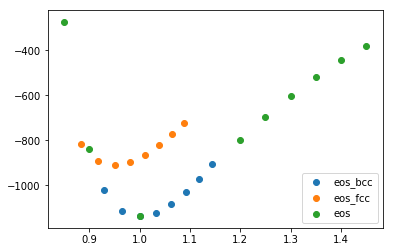

In [72]:
for key, trj in trjs.items():
    #print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    if 'eos' in key:
        plt.scatter([np.linalg.det(b)**(1./3.)/12.744894 for b in trj['box']][:-1], trj['energy'][:-1], label=key)
        print(trj['energy'][:])
plt.legend()
#plt.xlim(-1780,-1100)
plt.show()

In [73]:
def get_msd(xyzs):
    """Return mean squared displacement (msd) for a given trajectory (traj)."""
    msd = []
    for rs in xyzs:
        msd.append(np.mean((rs - xyzs[0])**2))
    #msd = [0.0 for _ in range(len(xyzs))]
    return np.array(msd)

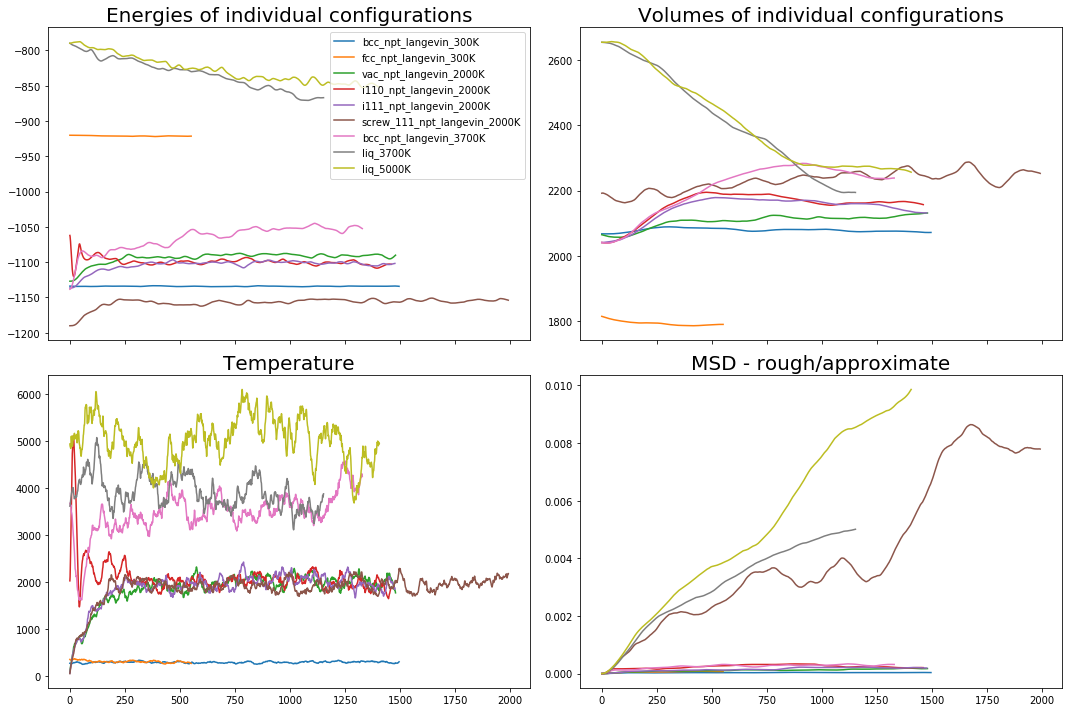

In [74]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(15,10))

for key, traj in trjs.items():
    if 'relax' in key or 'eos' in key:
        continue

        
    #axes[0,0].plot([e/x.shape[0] for e, x in zip(traj['energy'], traj['xyz'])], label=dset)
    if 'screw' in key:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)
    else:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)


    axes[1,0].plot([t for t in traj['temp']], label=key)

    msd = get_msd(traj['xyz'])
    axes[1,1].plot(msd, label=key)

axes[0,0].legend()
axes[0,0].set_title('Energies of individual configurations', fontsize=20)
axes[0,1].set_title('Volumes of individual configurations', fontsize=20)       
axes[1,0].set_title('Temperature', fontsize=20)
axes[1,1].set_title('MSD - rough/approximate', fontsize=20)
fig.tight_layout()

In [75]:
[(k, len(v['energy'])) for k, v in trjs.items()]

[('bcc_npt_langevin_300K', 1496),
 ('fcc_npt_langevin_300K', 552),
 ('vac_npt_langevin_2000K', 1480),
 ('i110_npt_langevin_2000K', 1461),
 ('i111_npt_langevin_2000K', 1477),
 ('screw_111_npt_langevin_2000K', 1992),
 ('bcc_npt_langevin_3700K', 1329),
 ('liq_3700K', 1153),
 ('liq_5000K', 1406),
 ('relax', 7),
 ('eos_bcc', 9),
 ('eos_fcc', 9),
 ('eos', 10)]

In [157]:
cuts = {'bcc_npt_langevin_300K':500,
        'fcc_npt_langevin_300K':50,
        'vac_npt_langevin_2000K':300,
        'i110_npt_langevin_2000K':1000,
        'i111_npt_langevin_2000K':1000,
        'screw_111_npt_langevin_2000K':1400,
        'bcc_npt_langevin_3700K':600,
        'liq_3700K':800,
        'liq_5000K':800,
        'relax':0,
        'eos_bcc':0,
        'eos_fcc':0,
        'eos':0,
       }

In [76]:
slices = {'bcc_npt_langevin_300K':slice(500, None,5),
        'fcc_npt_langevin_300K':slice(50, None, 5),
        'vac_npt_langevin_2000K':slice(300, None, 5),
        'i110_npt_langevin_2000K':slice(1000, None, 5),
        'i111_npt_langevin_2000K':slice(1000, None, 5),
        'screw_111_npt_langevin_2000K':slice(1400, None, 5),
        'bcc_npt_langevin_3700K':slice(600, None, 5),
        'liq_3700K':slice(800, None, 5),
        'liq_5000K':slice(800, None, 5),
        'relax':slice(0, None, None),
        'eos_bcc':slice(0, None, None),
        'eos_fcc':slice(0, None, None),
        'eos':slice(0, None, None)
       }

In [77]:
trj_samples = {}
for key, traj in trjs.items():
    trj_samples[key] = traj[slices[key]]

In [79]:
[(k, len(v['energy'])) for k, v in trj_samples.items()]

[('bcc_npt_langevin_300K', 200),
 ('fcc_npt_langevin_300K', 101),
 ('vac_npt_langevin_2000K', 236),
 ('i110_npt_langevin_2000K', 93),
 ('i111_npt_langevin_2000K', 96),
 ('screw_111_npt_langevin_2000K', 119),
 ('bcc_npt_langevin_3700K', 146),
 ('liq_3700K', 71),
 ('liq_5000K', 122),
 ('relax', 7),
 ('eos_bcc', 9),
 ('eos_fcc', 9),
 ('eos', 10)]

In [80]:
# join 0 K configurations into a pseudo-trajectory
traj_md = copy.deepcopy(trj_samples['bcc_npt_langevin_300K'])

for k, trj in trj_samples.items():
    print(k)
    if 'eos' in k or 'relax' in k or 'bcc_npt_langevin_300K' in k: 
        continue
        
    traj_md.append(trj)

    print(len(traj_md['box']))

bcc_npt_langevin_300K
fcc_npt_langevin_300K
301
vac_npt_langevin_2000K
537
i110_npt_langevin_2000K
630
i111_npt_langevin_2000K
726
screw_111_npt_langevin_2000K
845
bcc_npt_langevin_3700K
991
liq_3700K
1062
liq_5000K
1184
relax
eos_bcc
eos_fcc
eos


In [90]:
trj_samples['eos_bcc'].append(trj_samples['eos'])

In [91]:
trj_samples['eos_bcc']['energy']

[-1139.1553999999999,
 -1022.8066999999999,
 -1114.8183999999999,
 -1123.9361,
 -1084.6381,
 -1031.6408,
 -971.3192999999999,
 -907.6867,
 -2.9688679595213743e-239,
 -1139.2,
 -271.8047221070888,
 -837.1711089986524,
 -800.6633444635341,
 -697.0611202328876,
 -602.3043063713139,
 -517.742999456512,
 -443.4032853774631,
 -378.657941519064,
 -2.9688679595213743e-239]

In [92]:
trj_fit = {'md':traj_md, 'relax':trj_samples['relax'], 'eos_bcc':trj_samples['eos_bcc'], 'eos_fcc':trj_samples['eos_fcc']}

In [93]:
trj_fit['md']['xyz'][-1].shape

(113, 3)

In [94]:
trj_fit.keys()

dict_keys(['md', 'relax', 'eos_bcc', 'eos_fcc'])

In [95]:
with open(os.path.join(working, "trj_fit.pickle"), 'wb') as fo:
    pickle.dump(trj_fit, fo)

In [96]:
weights = {k:1.0 for k in trj_fit}
weights['relax'] = 20.0
weights['eos_bcc'] = 5
weights['eos_fcc'] = 5


target_data = {}

for key, trj in trj_fit.items():
    
    print('dataset #', key)

    # target data
    target_dict = {'type':'trajectory', 'weight':weights[key]}
    target_dict['box'] = trj['box']
    target_dict['xyz'] = trj['xyz']
    target_dict['energy'] = trj['energy']
    target_dict['forces'] = force_targ(trj['forces'])
    target_dict['temp'] = trj['temp']

    # save inverse temperature data (if T=0, set beta=1/300)
    target_dict['beta'] = np.empty_like(target_dict['temp'])
    for i, temp in enumerate(target_dict['temp']):
        if temp == 0.0:
            target_dict['beta'][i] = 1.0/300.0
        else:
            target_dict['beta'][i] = 1.0/temp

    target_dict['beta'] = list(target_dict['beta'])
            
    target_data[key] = target_dict

dataset # md
dataset # relax
dataset # eos_bcc
dataset # eos_fcc


In [97]:
with open(os.path.join(working, "target_samples.pickle"), 'wb') as fo:
    pickle.dump(target_data, fo)

In [98]:
# load target data
with open(os.path.join(working, 'target_samples'+'.pickle'), 'rb') as fi:
    targ_dict = pickle.load(fi)

In [173]:
#sc = [2.74, 3.252, 3.804, 4.356, 4.908, 5.46]
#sc = [2.74, 3.25, 3.75, 4.5, 5.48]
#sc = [2.375, 2.5, 2.75, 3.25, 3.75, 4.25, 4.5,  5., 5.5, 6.0 ]
sc = [2.4, 2.45, 2.5, 2.65, 2.70, 2.72, 2.73, 2.74, 2.75, 2.77, 2.80, 2.85, 2.90,
      3.0, 3.1, 3.2, 3.3, 3.45, 3.6, 3.75,
      4.0, 4.1, 4.25, 4.356, 4.5, 4.65, 4.8,
      5.0, 5.15, 5.3, 5.45, 5.6, 5.75]


#index = [0, 1, 3, 5, 8, 10]


In [174]:
stats_data = {}

stats_data['function'] = 'EAM-cubic-spline'
stats_data['hyperparams'] = sc

for key, trj in trj_fit.items():
    
    print('dataset #', key)
#    if 'relax' not in key:
#        continue

    # statistics data
    stats_dict = {'energy':[], 'forces':[]}
    for ii, (xyz, box) in enumerate(zip(trj['xyz'], trj['box'])):
        print('conf', ii)
        
        a1, ar, a2, f1, fr, f2 = get_stats_EAM_pairdist(xyz, box, sc=sc)

        #print(xyz.shape, box)
        #print('x', a1.shape, rr.shape, np.sum(np.abs(a1)))
        #print('x', a1.shape, ar, a1, a2)
        
        stats_dict['energy'].append(np.array([ar, a2, a1]))
        stats_dict['forces'].append(np.array([fr, f2, f1]))

        #stats_dict['forces'].append(np.array([fr, f2, f1]))
               # add dataset
            
        #print('conf:', len(traj['xyz']), box.max())
        # plot pair distances - 
        #if ii == 10:
        #    plt.hist(rr.flatten(),100, alpha=1.0,label=key, histtype='step')
        #    plt.xlim(2,6)
        #    plt.ylim(0,1500)
            
    #plt.legend()
    stats_data[key] = stats_dict
    
with open(os.path.join(working, "stats_backup.pickle"), 'wb') as fo:
    pickle.dump(stats_data, fo)

dataset # md
conf 0
conf 1
conf 2
conf 3
conf 4
conf 5
conf 6
conf 7
conf 8
conf 9
conf 10
conf 11
conf 12
conf 13
conf 14
conf 15
conf 16
conf 17
conf 18
conf 19
conf 20
conf 21
conf 22
conf 23
conf 24
conf 25
conf 26
conf 27
conf 28
conf 29
conf 30
conf 31
conf 32
conf 33
conf 34
conf 35
conf 36
conf 37
conf 38
conf 39
conf 40
conf 41
conf 42
conf 43
conf 44
conf 45
conf 46
conf 47
conf 48
conf 49
conf 50
conf 51
conf 52
conf 53
conf 54
conf 55
conf 56
conf 57
conf 58
conf 59
conf 60
conf 61
conf 62
conf 63
conf 64
conf 65
conf 66
conf 67
conf 68
conf 69
conf 70
conf 71
conf 72
conf 73
conf 74
conf 75
conf 76
conf 77
conf 78
conf 79
conf 80
conf 81
conf 82
conf 83
conf 84
conf 85
conf 86
conf 87
conf 88
conf 89
conf 90
conf 91
conf 92
conf 93
conf 94
conf 95
conf 96
conf 97
conf 98
conf 99
conf 100
conf 101
conf 102
conf 103
conf 104
conf 105
conf 106
conf 107
conf 108
conf 109
conf 110
conf 111
conf 112
conf 113
conf 114
conf 115
conf 116
conf 117
conf 118
conf 119
conf 120
conf 121

conf 789
Replicating: 1 5 1
conf 790
Replicating: 1 5 1
conf 791
Replicating: 1 5 1
conf 792
Replicating: 1 5 1
conf 793
Replicating: 1 5 1
conf 794
Replicating: 1 5 1
conf 795
Replicating: 1 5 1
conf 796
Replicating: 1 5 1
conf 797
Replicating: 1 5 1
conf 798
Replicating: 1 5 1
conf 799
Replicating: 1 5 1
conf 800
Replicating: 1 5 1
conf 801
Replicating: 1 5 1
conf 802
Replicating: 1 5 1
conf 803
Replicating: 1 5 1
conf 804
Replicating: 1 5 1
conf 805
Replicating: 1 5 1
conf 806
Replicating: 1 5 1
conf 807
Replicating: 1 5 1
conf 808
Replicating: 1 5 1
conf 809
Replicating: 1 5 1
conf 810
Replicating: 1 5 1
conf 811
Replicating: 1 5 1
conf 812
Replicating: 1 5 1
conf 813
Replicating: 1 5 1
conf 814
Replicating: 1 5 1
conf 815
Replicating: 1 5 1
conf 816
Replicating: 1 5 1
conf 817
Replicating: 1 5 1
conf 818
Replicating: 1 5 1
conf 819
Replicating: 1 5 1
conf 820
Replicating: 1 5 1
conf 821
Replicating: 1 5 1
conf 822
Replicating: 1 5 1
conf 823
Replicating: 1 5 1
conf 824
Replicating

In [178]:
[(i, x) for i, x in enumerate(stats_data['eos']['energy'])]

[(0, array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.97877344e-01, 2.96713895e+00, 9.88105080e+00,
          1.90968741e+01, 4.27397943e+01, 7.19807902e+01, 1.05900954e+02,
          1.44424622e+02, 2.12094835e+02, 2.91258312e+02, 3.80847597e+02,
          5.50703944e+02, 6.25169446e+02, 7.43292834e+02, 8.31179888e+02,
          9.56126091e+02, 1.09303139e+03, 1.23772394e+03, 1.44385975e+03,
          1.60867205e+03, 1.78223976e+03, 1.96489622e+03, 2.15797587e+03,
          2.36273278e+03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 1.19499732e-08, 3.69591208e-05, 4.54551001e-03,
          6.34189762e-02, 1.59110852e+00, 1.28007829e+01, 5.99749067e+01,
          2.07460322e+02, 9.64918112e+02, 3.43149528e+03, 1.00317100e+04,
        

In [179]:
with open(os.path.join(working, "stats_complete.pickle"), 'wb') as fo:
    pickle.dump(stats_data, fo)

In [180]:
#%%writefile -a ../src/optimize/optscript.py

from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print
from scipy.optimize import fmin

In [221]:
#%%writefile -a ../src/optimize/optscript.py

# load stats data
with open(os.path.join(working, 'stats_complete'+'.pickle'), 'rb') as fi:
    stats_dict = pickle.load(fi)

In [222]:
# load target data
with open(os.path.join(working, 'target_complete'+'.pickle'), 'rb') as fi:
    targ_dict = pickle.load(fi)

In [202]:
#%%writefile -a ../src/optimize/optscript.py

# load stats data
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_dict = pickle.load(fi)

In [203]:
#%%writefile -a ../src/optimize/optscript.py
#pars_in = [pars_dict['embed'][0], pars_dict['embed'][2], *pars_dict['pair']]
#pars_in = pars_dict['embed'] + pars_dict['pair']
#print(pars_in)

TypeError: list indices must be integers or slices, not str

In [224]:
len(targ_dict['md']['energy']), len(stats_dict['md']['energy'])

(1184, 1184)

In [225]:
# Final scaling and normalization of data
# %load ../src/optimize/optscript.py

# scale energies (subtract energy of an isolated atom)
# determine interaction energy
print(targ_dict['relax']['energy'][0], len(targ_dict['relax']['xyz'][0]))
u_t = targ_dict['relax']['energy'][0]/len(targ_dict['relax']['xyz'][0])
u_e = -8.9 # external energy from atom (experimental)
u_i = u_t - u_e # internal energy per atom (to be subtracted from all atoms)
print(u_t, u_e, u_i)

emin = 0.0
esum = 0.0
isum = 0.0
lemin = 0.0
lesum = 0.0
lisum = 0.0
for key, trj in targ_dict.items():
    #if 'eos' in key:
    #    continue
    for i in range(len(targ_dict[key]['energy'])):
        targ_dict[key]['energy'][i] -= u_i*targ_dict[key]['xyz'][i].shape[0]
        enex = targ_dict[key]['energy'][i]/targ_dict[key]['xyz'][i].shape[0]

#        if 'fcc' in key:
#            esum += enex
#            isum += 1.0
#            if enex < emin:
#                imin = i
#                #print(enex)
#                emin = enex
#                xmin = targ_dict[key]['xyz'][i]
#                bmin = targ_dict[key]['box'][i]
#                smin = stats_dict[key]['energy'][i]

#        if 'liq_5000K' in key:
#            lesum += enex
#            lisum += 1.0
#            if enex < lemin:
#                limin = i
#                #print(enex)
#                lemin = enex
#                lxmin = targ_dict[key]['xyz'][i]
#                lbmin = targ_dict[key]['box'][i]
#                lsmin = stats_dict[key]['energy'][i]
#                lnat = targ_dict[key]['xyz'][i].shape[0]

#print('Emin', emin, esum/isum)

# temporary fix - set fcc energy at 0K to minimum energy of 300K trajectory
#targ_dict['relax']['energy'][1] = emin*targ_dict['relax']['xyz'][1].shape[0]
#targ_dict['relax']['xyz'][1] = xmin
#targ_dict['relax']['box'][1] = bmin
#stats_dict['relax']['energy'][1] = smin

#targ_dict['relax']['energy'][5] = lemin*lnat
#targ_dict['relax']['xyz'][5] = lxmin
#targ_dict['relax']['box'][5] = lbmin
#stats_dict['relax']['energy'][5] = lsmin

#targ_dict['relax']['energy'][-1] = 0.0

targ_dict['relax']['energy'][5] = targ_dict['relax']['energy'][6]
targ_dict['relax']['xyz'][5] = targ_dict['relax']['xyz'][6]
targ_dict['relax']['box'][5] = targ_dict['relax']['box'][6]
stats_dict['relax']['energy'][5] = stats_dict['relax']['energy'][6]

print('OK energies:', targ_dict['relax']['energy'])

-1656.3257 128
-12.94004453125 -8.9 -4.04004453125
OK energies: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498, 0.0, 0.0]


In [226]:
print('OK energies:', targ_dict['eos']['energy'])

OK energies: [-1139.2, -271.80472210708876, -837.1711089986525, -800.663344463534, -697.0611202328876, -602.3043063713139, -517.742999456512, -443.40328537746313, -378.657941519064, 0.0]


In [227]:
print('OK energies:', targ_dict['eos_bcc']['energy'])

OK energies: [-1139.1553999999999, -1022.8066999999999, -1114.8183999999999, -1123.9361, -1084.6381, -1031.6408, -971.3192999999999, -907.6867, 0.0]


In [228]:
print('OK energies:', targ_dict['eos_fcc']['energy'])

OK energies: [-910.2984906249999, -910.2984906249999, -816.6878906249999, -890.3537906249999, -897.8806906249999, -865.893990625, -822.6411906249998, -773.407790625, -721.4408906249998, 0.0]


In [229]:
targ_dict['eos_fcc']['box']

[array([[12.117443,  0.      ,  0.      ],
        [ 0.      , 12.117443,  0.      ],
        [ 0.      ,  0.      , 12.117443]]),
 array([[12.117443,  0.      ,  0.      ],
        [ 0.      , 12.117443,  0.      ],
        [ 0.      ,  0.      , 12.117443]]),
 array([[11.248838,  0.      ,  0.      ],
        [ 0.      , 11.248838,  0.      ],
        [ 0.      ,  0.      , 11.248838]]),
 array([[11.699263,  0.      ,  0.      ],
        [ 0.      , 11.699263,  0.      ],
        [ 0.      ,  0.      , 11.699263]]),
 array([[12.508595,  0.      ,  0.      ],
        [ 0.      , 12.508595,  0.      ],
        [ 0.      ,  0.      , 12.508595]]),
 array([[12.876705,  0.      ,  0.      ],
        [ 0.      , 12.876705,  0.      ],
        [ 0.      ,  0.      , 12.876705]]),
 array([[13.224891,  0.      ,  0.      ],
        [ 0.      , 13.224891,  0.      ],
        [ 0.      ,  0.      , 13.224891]]),
 array([[13.555649,  0.      ,  0.      ],
        [ 0.      , 13.555649,  0.      

In [230]:
targ_dict['relax']['box']

[array([[12.744894,  0.      ,  0.      ],
        [ 0.      , 12.744894,  0.      ],
        [ 0.      ,  0.      , 12.744894]]),
 array([[12.10561061,  0.        ,  0.        ],
        [ 0.        , 12.10561061,  0.        ],
        [ 0.        ,  0.        , 12.10561061]]),
 array([[12.729505,  0.      ,  0.      ],
        [ 0.      , 12.729505,  0.      ],
        [ 0.      ,  0.      , 12.729505]]),
 array([[12.6836,  0.    ,  0.    ],
        [ 0.    , 12.6836,  0.    ],
        [ 0.    ,  0.    , 12.6836]]),
 array([[12.6836,  0.    ,  0.    ],
        [ 0.    , 12.6836,  0.    ],
        [ 0.    ,  0.    , 12.6836]]),
 array([[1274.4894,    0.    ,    0.    ],
        [   0.    , 1274.4894,    0.    ],
        [   0.    ,    0.    , 1274.4894]]),
 array([[1274.4894,    0.    ,    0.    ],
        [   0.    , 1274.4894,    0.    ],
        [   0.    ,    0.    , 1274.4894]])]

In [231]:
#Add Inf configurations at the end of the MD trajectory
for key in targ_dict['md']:
    if 'type' in key or 'weight' in key:
        continue
    #print(key, type(targ_dict['md'][key][-1]))
    for i in range(100):
        targ_dict['md'][key].append(targ_dict['relax'][key][-1])

In [232]:
stats_dict['md'].keys()
for key in stats_dict['md']:
    #print(key, type(stats_dict['md'][key]))
    for i in range(100):
        stats_dict['md'][key].append(stats_dict['relax'][key][-1])

In [233]:
for key in targ_dict['md']:
    if 'type' in key or 'weight' in key:
        continue
    #print(key, len(stats_dict['md'][key]), type(stats_dict['md'][key]))
    print(key, len(targ_dict['md'][key]), type(targ_dict['md'][key]))
    if key == 'energy':
        print(key, len(stats_dict['md'][key]), type(stats_dict['md'][key]))

box 1284 <class 'list'>
xyz 1284 <class 'list'>
energy 1284 <class 'list'>
energy 1284 <class 'list'>
forces 1284 <class 'list'>
temp 1284 <class 'list'>
beta 1284 <class 'list'>


In [234]:
#targ_dict['eos']['weight'] = 1.0

In [235]:
#targ_dict['relax']['weight'] = 20.0
targ_dict['eos_bcc']['weight'] = 0.5
targ_dict['eos_fcc']['weight'] = 0.5
#targ_dict['md']['weight'] = 5.0
print([targ_dict[k]['weight'] for k in targ_dict])

[1.0, 20.0, 0.5, 0.5, 0.5]


In [236]:
print([2.74, 3.252, 3.804, 4.356, 4.908, 5.46])
print(stats_dict['hyperparams'])

[2.74, 3.252, 3.804, 4.356, 4.908, 5.46]
[2.4, 2.45, 2.5, 2.65, 2.7, 2.72, 2.73, 2.74, 2.75, 2.77, 2.8, 2.85, 2.9, 3.0, 3.1, 3.2, 3.3, 3.45, 3.6, 3.75, 4.0, 4.1, 4.25, 4.356, 4.5, 4.65, 4.8, 5.0, 5.15, 5.3, 5.45, 5.6, 5.75]


In [237]:
with open(os.path.join(working, "stats_clean.pickle"), 'wb') as fo:
    pickle.dump(stats_dict, fo)
with open(os.path.join(working, "target_clean.pickle"), 'wb') as fo:
    pickle.dump(targ_dict, fo)

In [218]:
with open(os.path.join(working, 'stats_clean'+'.pickle'), 'rb') as fi:
    stats_ready = pickle.load(fi)
with open(os.path.join(working, 'target_clean'+'.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [1328]:
#%%writefile -a ../../statmechlib/statmechlib/preprocessing/stats.py

def select_nodes(stats_input, index):
    """
    Select only configuration statistics from stats (spline nodes) that are given in index.
    """
    
    stats_select = copy.deepcopy(stats_input)
    
    for key, stats in stats_select.items():
        if type(stats) == dict and 'energy' in stats.keys():
            for i, conf in enumerate(stats['energy']):
                new_conf = np.empty((3, sum(index)), dtype=float)
                new_conf[0] = conf[0][index]
                new_conf[1] = conf[1][index]
                new_conf[2] = conf[2][index]
                stats['energy'][i] = new_conf
                
    stats_select['hyperparams'] = list(np.array(stats_select['hyperparams'])[index])

    return stats_select

Appending to ../../statmechlib/statmechlib/preprocessing/stats.py


[autoreload of statmechlib.preprocessing failed: Traceback (most recent call last):
  File "//anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "//anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "//anaconda/envs/py36/lib/python3.6/imp.py", line 314, in reload
    return importlib.reload(module)
  File "//anaconda/envs/py36/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 205, in _call_with_frames_removed
  File "../../statmechlib/statmechlib/preprocessing/__init__.py", line 5, in <module>
    from .stats import force_targ, select_nodes
ImportError: cannot import name 'select

In [1362]:
stats_opt = copy.deepcopy(stats_ready)

In [1131]:
#index = [2, 4, 6, 9, 12, 14]
index = [0, 2, 4, 6, 8, 11, 13, 15]
index = np.array([True if i in index else False for i in range(len(stats_ready['hyperparams']))])
print(np.array(stats_ready['hyperparams'])[index])
stats_opt = select_nodes(stats_ready, index)

In [1327]:
# prepare data for fitting
stats = []
target = []
for key in list(targ_ready.keys()):
    stats.append(stats_opt[key])
    target.append(targ_ready[key])

In [1138]:
multi_pars = [pars_in]

In [1139]:
multi_pars

[[-0.344540412587315,
  1.6869558429105695e-05,
  0.4527535290774057,
  7.091857873610367,
  1.6314949612839302,
  0.7906877956550405,
  -0.8249673243680319,
  0.14501087706040938,
  -0.002061634677032549,
  0.0021894588902290147]]

In [1141]:
pars = multi_pars[0]
#optimal_parameters = []
print(pars)
sd_ini = sd2_loss(pars, stats, target, utot_EAM, None, [4])
print('Initial sd2:', sd_ini)
output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM, None, [4]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
params_uopt = output[0]
print('Opt #', 0, output[1:])
print("Optimized parameters:")
print(*params_uopt)

[-0.344540412587315, 1.6869558429105695e-05, 0.4527535290774057, 7.091857873610367, 1.6314949612839302, 0.7906877956550405, -0.8249673243680319, 0.14501087706040938, -0.002061634677032549, 0.0021894588902290147]
Initial sd2: 9.63204000350986
Opt # 0 (0.03746468788767358, 2086, 3023, 0)
Optimized parameters:
4.262274411841073 7.663340075341373e-05 2.939854626564106 25.89146156136932 -0.9880332808876793 3.768038010607329 -0.6536280853810048 -0.13579513361882128 -0.12201413072423531 -0.12951203275555268


In [1147]:
optimal_parameters.append(tuple([output[1:], params_uopt]))

In [1161]:
multi_pars =[pars_in]

In [1162]:
multi_pars.append(list(params_uopt))

In [1163]:
multi_pars

[[-0.344540412587315,
  1.6869558429105695e-05,
  0.4527535290774057,
  7.091857873610367,
  1.6314949612839302,
  0.7906877956550405,
  -0.8249673243680319,
  0.14501087706040938,
  -0.002061634677032549,
  0.0021894588902290147],
 [4.262274411841073,
  7.663340075341373e-05,
  2.939854626564106,
  25.89146156136932,
  -0.9880332808876793,
  3.768038010607329,
  -0.6536280853810048,
  -0.13579513361882128,
  -0.12201413072423531,
  -0.12951203275555268]]

In [1285]:
# Formatting for optimization
multi_pars = []

#pars_in1 = multi_pars[0]
#pars_in2 = multi_pars[1]
#pars_in3 = multi_pars[1]


pars_in1 = optimal_parameters[0][1]
pars_in2 = optimal_parameters[2][1]
pars_in3 = optimal_parameters[26][1]


#pars_in1 = [-2.21684325e+00, -1.77860942e-04, -3.66546338e+00, -1.71191389e+00, 4.38944526e+00, -2.66122494e+00,  7.24452435e-01,  2.29732818e-01]
#pars_in2 = [-1.27104003e+00, -4.74103470e-05, -1.81120680e+01, -1.95915397e+00, 4.09985823e+00, -1.83714241e+00, -1.61099628e-02,  2.92927073e-01]

print(pars_in1)
print(pars_in2)
print(pars_in3)

multi_pars.append(pars_in1)
multi_pars.append(pars_in2)
multi_pars.append(pars_in3)

for _ in range(5):
    pars = np.array(pars_in1)
    pars += np.random.standard_normal(pars.shape)*0.07
    print(pars)
    multi_pars.append(pars)

for _ in range(5):
    pars = np.array(pars_in2)
    pars += np.random.standard_normal(pars.shape)*0.07
    multi_pars.append(pars)

for _ in range(5):
    pars = np.array(pars_in3)
    pars += np.random.standard_normal(pars.shape)*0.07
    multi_pars.append(pars)
    
for _ in range(5):
    pars = 0.5*(np.array(pars_in1) + np.array(pars_in2))
    pars += np.random.standard_normal(pars.shape)*0.07
    multi_pars.append(pars)

for _ in range(5):
    pars = 0.5*(np.array(pars_in1) + np.array(pars_in3))
    pars += np.random.standard_normal(pars.shape)*0.07
    multi_pars.append(pars)

for _ in range(5):
    pars = 0.5*(np.array(pars_in2) + np.array(pars_in3))
    pars += np.random.standard_normal(pars.shape)*0.07
    multi_pars.append(pars)

[-1.55157224e+00  6.19313883e-04 -2.40345053e-01  1.47964187e+01
 -5.21331770e+00  6.55630207e+00 -4.21290956e+00  1.38589665e+00
  4.05508870e-01 -3.08873244e-01]
[-1.01109934e+00  9.12551310e-04  7.38144313e-01  1.35396139e+01
 -3.93098577e+00  5.62823368e+00 -3.90553121e+00  1.60239127e+00
  8.01345922e-02 -2.20808888e-01]
[-8.75130097e-01  1.01495436e-03 -1.05803486e+00  1.44309978e+01
 -5.11082666e+00  6.19359023e+00 -3.79499306e+00  1.16196819e+00
  3.84480602e-01 -2.98950645e-01]
[-1.46109153 -0.06345735 -0.44672081 14.85315402 -5.31142649  6.59316527
 -4.29503461  1.29558581  0.45184516 -0.29768911]
[-1.60645515e+00 -3.96316263e-03 -2.04051635e-01  1.47660960e+01
 -5.21819489e+00  6.60089664e+00 -4.27756494e+00  1.48607488e+00
  4.98705061e-01 -2.49869465e-01]
[-1.65573826  0.06494044 -0.20881026 14.82784664 -5.18095915  6.4757687
 -4.19745527  1.4475494   0.47102954 -0.30289132]
[-1.54327893  0.03108082 -0.19416963 14.81956073 -5.17076549  6.58617515
 -4.27796891  1.2900605   

In [ ]:
optimal_parameters = []
for iemb in range(2, len(stats_opt['hyperparams']))
    for i, pars in enumerate(multi_pars):
        sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [4])
        print('Initial sd2:', sd_ini)
        output = fmin(sd2_loss, list(pars), args=(stats, target, utot_EAM, None, [4]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
        params_uopt = output[0]
        print('Opt #', i, output[1:])
        print("Optimized parameters:")
        print(*params_uopt)
        optimal_parameters.append(tuple([output[1:], params_uopt]))

In [1286]:
optimal_parameters = []
for i, pars in enumerate(multi_pars):
    sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [4])
    print('Initial sd2:', sd_ini)
    output = fmin(sd2_loss, list(pars), args=(stats, target, utot_EAM, None, [4]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
    params_uopt = output[0]
    print('Opt #', i, output[1:])
    print("Optimized parameters:")
    print(*params_uopt)
    optimal_parameters.append(tuple([output[1:], params_uopt]))

Initial sd2: 0.0004354418880580194
Opt # 0 (0.0004354388576933695, 962, 1434, 0)
Optimized parameters:
-1.5500437168374792 0.0006208601497296422 -0.23868836055398499 14.79076033984127 -5.213509100904539 6.555820341637123 -4.212408896028465 1.3855276769586866 0.4055166025390601 -0.30888291960346514
Initial sd2: 0.000711401907683944
Opt # 1 (0.0006959441592098408, 2379, 3432, 0)
Optimized parameters:
-0.9704693218042414 0.0009873475928607717 -0.4621621587760023 13.758768145442179 -4.074108190219097 5.603464185079707 -3.8257600732108252 1.5271207173092223 0.11230856301487346 -0.22760832812879309
Initial sd2: 0.0007057348089235475
Opt # 2 (0.0005058052222426564, 2272, 3216, 0)
Optimized parameters:
-1.2187822829261485 0.0008080883569445773 -0.5736797036418428 14.426999658335577 -4.680946991192258 6.087626915359692 -3.9891957527886355 1.4247380480466432 0.2697688489961608 -0.27053339859443515
Initial sd2: 21.548463188404487


../../statmechlib/statmechlib/forcefields/eam.py:226: RuntimeWarning: overflow encountered in exp
  #print('ustat', utot_func(params, u_stat))


Opt # 3 (0.0005006654936858322, 1662, 2458, 0)
Optimized parameters:
-1.7217469482695151 0.0005175312648515516 -0.06599181153583186 15.340240063752208 -5.888411745358239 7.002406691173711 -4.307766842309783 1.2339624329162717 0.5737127870389307 -0.3537622334972519
Initial sd2: 20.933645793521013
Opt # 4 (0.0006262983650442252, 2012, 2901, 0)
Optimized parameters:
-1.7307860588839954 0.0003513040891229383 -0.15195956295865504 16.607601620005653 -5.962813597616453 6.9996203251686815 -4.184882909812048 1.1406312034966217 0.6081735921980559 -0.35894531464095325
Initial sd2: 21.6726590460639
Opt # 5 (0.0016643507194659514, 1987, 2892, 0)
Optimized parameters:
-1.8750665974472795 0.0011544459703385134 -0.21816839343731975 10.611024100033756 -6.233143504891394 7.166119966465428 -4.549388802055104 1.21968214457686 0.6857596780403046 -0.3881189185832513
Initial sd2: 20.84600897386559
Opt # 6 (0.0005436355809552974, 1324, 1946, 0)
Optimized parameters:
-1.8542336821909888 0.0004333995124211909 -

Opt # 31 (0.0006159019142651392, 1734, 2520, 0)
Optimized parameters:
-1.1189392057162197 0.0005137846731296616 -0.16176433164422896 16.123927007780427 -4.823684149629987 6.33473367718456 -3.972343984997062 1.3162786015759065 0.34244737485150906 -0.2909146347404694
Initial sd2: 21.809865924709275
Opt # 32 (0.0008924805842866051, 2012, 2916, 0)
Optimized parameters:
-1.2772090718051015 0.00027903001026481243 -0.1999390610997685 16.87426813722279 -3.99588530866668 5.947331243101901 -4.052143626404343 1.6477605774200912 0.1222794423813943 -0.23503629645274315


5
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498]
Model: [-1139.055520393923, -907.0405173710939, -1126.8875750628988, -1137.5465575306353, -1135.7205910721989]
[0.0390625  0.0462963  0.03937008 0.03875969 0.03875969]
0 0.0004354388576933695
2 0.0005058052222426564
3 0.0005006654936858322
6 0.0005436355809552974
13 0.00044108895740836566
17 0.0005975793688722613
19 0.0005723898954054334
20 0.0005042031397132865
21 0.0005323464775563254
22 0.0005332112942286811
26 0.0005390274456422927


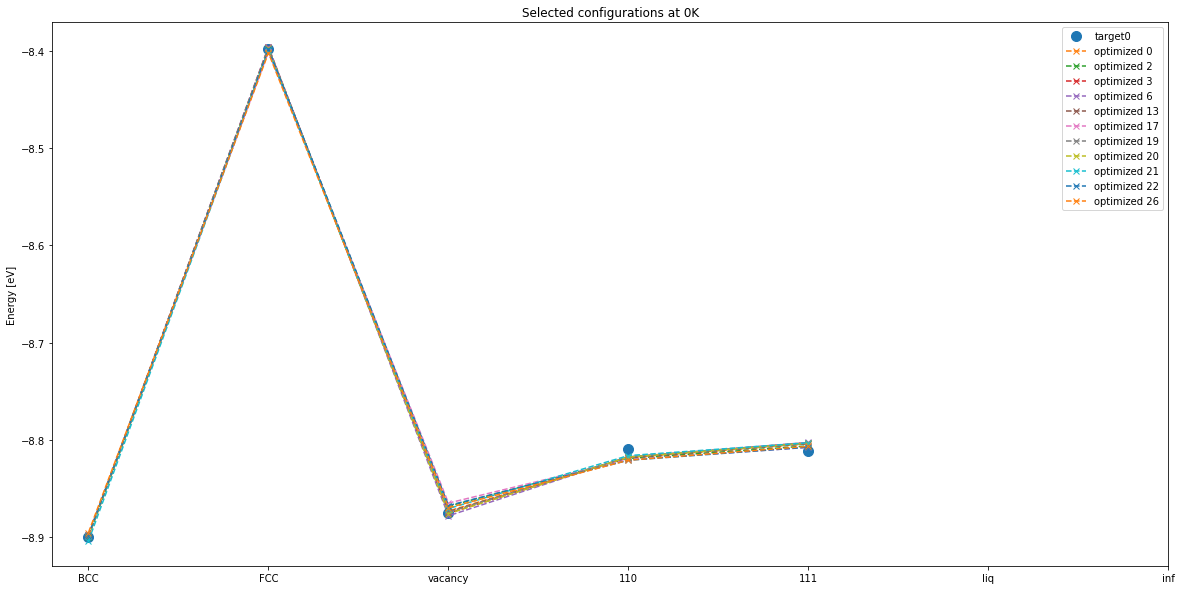

In [1287]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_dict['relax']['xyz']])[:-2]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [4])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-2][:-2])
        print('Model:', opti_out[-2][:-2])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-2][:-2]))/nat)
        plt.plot(np.array(targ_out[-2][:-2])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0][0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0][0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-2][:-2]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

15
Targ: [845.2656372627717, -271.80472210709036, -837.1711089986524, -1079.5267350307167, -1139.2, -1100.8887858645915, -1014.6561261471662, -909.2807161131147, -800.6633444635341, -697.0611202328876, -602.3043063713139, -517.742999456512, -443.4032853774631, -378.657941519064, -322.6037245559544]
Model: [843.2584809287787, -277.0572583563726, -830.8455833447576, -1091.4490586448856, -1139.055520393923, -1101.6157461686537, -1020.29998281799, -909.986355599721, -800.9046115650999, -703.5567723144138, -610.3220380943214, -517.8563481991345, -438.3839104854373, -377.5474084988842, -330.63571466243786]
[0.1171875 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875
 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875
 0.1171875]
0 0.0004354388576933695
2 0.0005058052222426564
3 0.0005006654936858322
6 0.0005436355809552974
13 0.00044108895740836566
17 0.0005975793688722613
19 0.0005723898954054334
20 0.0005042031397132865
21 0.0005323464775563254
22 0.00053321129

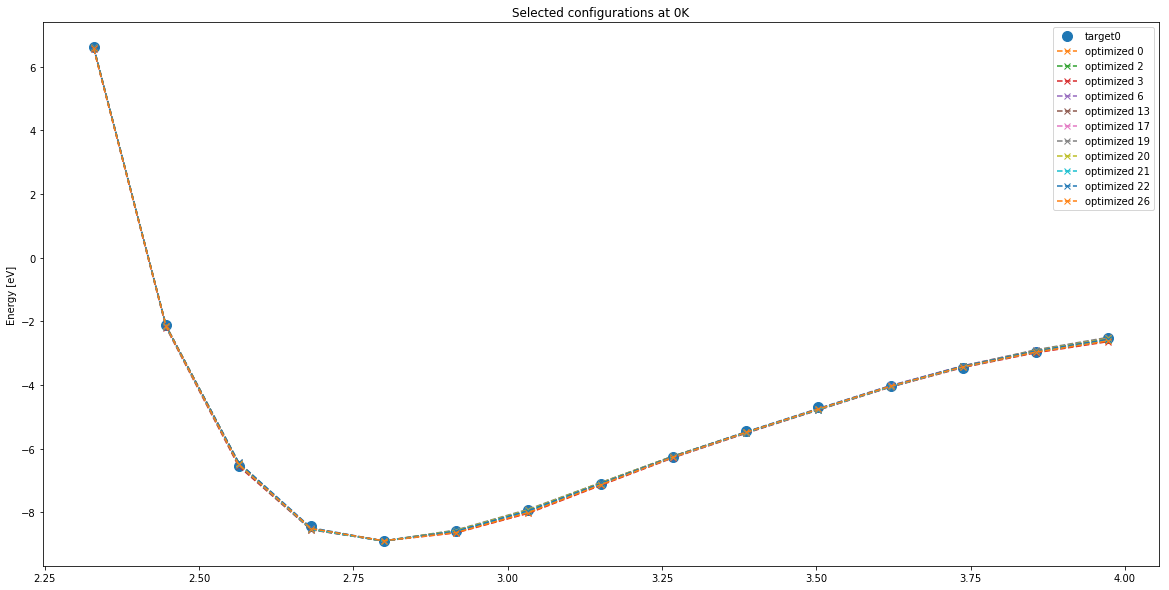

In [1288]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_dict['eos']['xyz']])[1:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [4])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][1:])
        print('Model:', opti_out[-1][1:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][1:]))/nat)
        plt.plot(reos, np.array(targ_out[-1][1:])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0][0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0][0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(reos, np.array([o for o in opti_out[-1][1:]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

1038
[8.109375   8.109375   8.109375   ... 9.18584071 9.18584071 9.18584071]
0 0.0004354388576933695
2 0.0005058052222426564
3 0.0005006654936858322
6 0.0005436355809552974
13 0.00044108895740836566
17 0.0005975793688722613
19 0.0005723898954054334
20 0.0005042031397132865
21 0.0005323464775563254
22 0.0005332112942286811
26 0.0005390274456422927


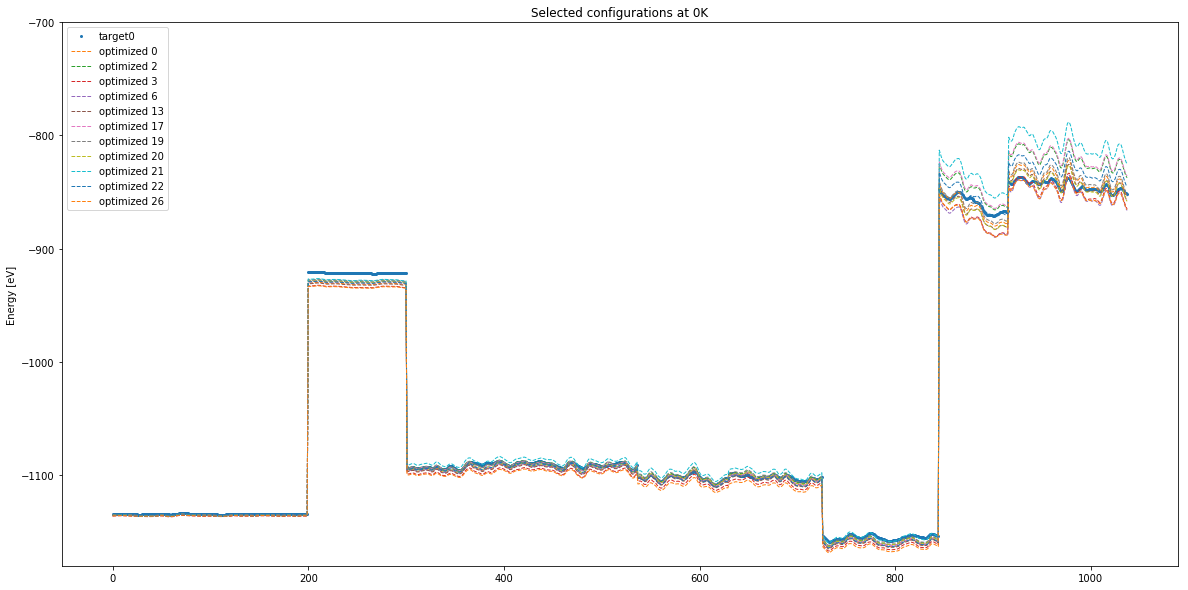

In [1290]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_dict['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[4])
    plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=2)

        
    if params_uopt[0][0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0][0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

plt.ylim(-1180,-700)
#plt.ylim(-1136,-1132)
#plt.ylim(-1000,-900)

plt.legend()

In [1276]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0][0] > 1.1e-3:
        continue
    print(i, params_uopt[0][0], '\n', params_uopt[1])


0 0.0004354418880580194 
 [-1.55157224e+00  6.19313883e-04 -2.40345053e-01  1.47964187e+01
 -5.21331770e+00  6.55630207e+00 -4.21290956e+00  1.38589665e+00
  4.05508870e-01 -3.08873244e-01]
1 0.0005107086380989782 
 [-1.42777825e+00  6.86369876e-04 -2.86779119e+00  1.58345726e+01
 -5.54279341e+00  6.55789464e+00 -4.01838505e+00  1.19067771e+00
  4.86745272e-01 -3.25730900e-01]
2 0.000711401907683944 
 [-1.01109934e+00  9.12551310e-04  7.38144313e-01  1.35396139e+01
 -3.93098577e+00  5.62823368e+00 -3.90553121e+00  1.60239127e+00
  8.01345922e-02 -2.20808888e-01]
3 0.0010293822802698838 
 [-1.57488462e+00  4.12117440e-04 -2.42795344e+00  1.69244672e+01
 -4.86163999e+00  6.11970592e+00 -3.87112392e+00  1.31716651e+00
  3.50851701e-01 -2.83664639e-01]
4 0.0004931888614860465 
 [-1.26213733e+00  8.29479470e-04 -2.17537005e+00  1.49186612e+01
 -5.16455530e+00  6.31718406e+00 -3.98178190e+00  1.27763287e+00
  3.90703910e-01 -3.01661661e-01]
6 0.0005095304399011984 
 [-1.21118220e+00  7.54284

In [1279]:
pars_out = {}
pars_out['pair_nodes'] = stats_opt['hyperparams']
pars_out['mb_node'] = stats_opt['hyperparams'][4]

In [1278]:
pars_list = [optimal_parameters[0], optimal_parameters[2], optimal_parameters[26]]

In [1280]:
pars_out['params'] = pars_list

In [1281]:
#pars_out
#optimal_list = [pars_out]

In [1282]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

if type(optimal_list) != list:
    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [1283]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [1284]:
optimal_list

[{'pair_nodes': [2.75, 3.25, 3.75, 4.356, 5.0, 5.5],
  'mb_node': [5.0],
  'params': [array([-6.40384877e-01,  4.55425528e-05,  1.47595943e+01, -3.28931140e+00,
           3.00810716e+00, -1.45207164e+00,  3.64513813e-01, -4.73088297e-02]),
   array([-8.22483533e-01,  8.94376574e-06,  1.98340385e+01, -3.35142547e+00,
           3.18038537e+00, -1.34334125e+00,  1.74653347e-01,  6.60838309e-02])]},
 {'pair_nodes': [2.5, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75],
  'mb_node': [4.25],
  'params': [((0.0016024158702214685, 2927, 4212, 0),
    array([-6.06235166e-01,  1.27132925e-03, -2.09926568e+00,  1.35247449e+01,
           -3.95514000e+00,  5.32105698e+00, -3.60023508e+00,  1.43574082e+00,
            8.20651339e-02, -2.18013211e-01]))]},
 {'pair_nodes': [2.5, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75],
  'mb_node': 4.25,
  'params': [((0.0011513028162758142, 4385, 6122, 0),
    array([-1.39430436e+00,  9.74288514e-04, -1.95722136e+00,  1.39902536e+01,
           -5.21661190e+00,  6.263

In [1230]:
# W parameters
l = 0.274
r_wse = 3.168
r_wse = 1.584
eta = 5.69
dE = 8.9

# equation of state. x is lattice expansion/compression parameter
def eos(x):
    a = (x - 1.0)*r_wse/l
    ene = np.exp(-a)
    ene *= -1.0 - a - 0.05*a**3
    return dE*ene

In [1231]:
f_spline = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

# electronic density function (cubic splines)
#rho = lambda r, a, k: sum([c*(p - r)**3 for c, p in zip(a, k) if r < p])

rho = f_spline

# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# pair potential function (same spline form as electronic density)
V = rho

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Embedding function. Parameters: electronic density (d), coefficients for 1/2, 1, and 2 powers of density
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# Cohesive potential (cubic splines - same form as V)
phi = V

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,
         0.,  6.,  0.,  0.,  0.,  0.,  0., 12.,  0.,  0., 24.,  0.,  8.,
         0.,  0.,  3.,  0.,  0., 24., 12.,  0.,  0., 12.,  0.,  8.,  0.,
         0.,  3.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  0.22074804,  0.44149608,  0.66224412,  0.88299216,
         1.1037402 ,  1.32448824,  1.54523628,  1.76598432,  1.98673236,
         2.20748039,  2.42822843,  2.64897647,  2.86972451,  3.09047255,
         3.31122059,  3.53196863,  3.75271667,  3.97346471,  4.19421275,
         4.41496079,  4.63570883,  4.85645687,  5.07720491,  5.29795295,
         5.51870099,  5.73944903,  5.96019707,  6.1809451 ,  6.40169314,
         6.62244118,  6.84318922,  7.06393726,  7.2846853 ,  7.50543334,
         7.72618138,  7.94692942,  8.16767746,  8.3884255 ,  8.60917354,
         8.82992158,  9.05066962,  9.27141766,  9.4921657 ,  9.71291374,
         9.93366178, 10.15440981, 10.37515785, 10.59590589,

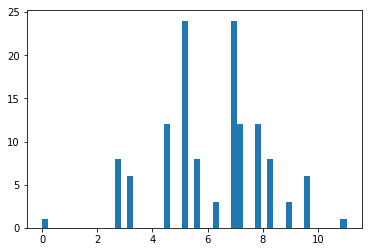

In [1339]:
from statmechlib.preprocessing import pair_dist_cutoff, force_targ
# Total pair potential
pos = targ_dict['relax']['xyz'][0]
bx = targ_dict['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

plt.hist(rr[0], 50)
#r = np.linspace(0., rcut, 201)

In [1233]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

In [1234]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_parameters[1][1][2:]
par = optimal_parameters[1][1][:2]
many_y = [par[0], 0.0, par[1]]

In [1235]:
#many_y = [multi_pars[0][0], 0.0, multi_pars[0][1]]
#pair_y = multi_pars[0][2:]

In [1246]:
#V_x_r = [2.5, 2.75, 3.25, 3.75, 4.5, 5.5]
V_x_r = stats_opt['hyperparams']
rho_x_r = stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [1247]:
stats_opt['hyperparams'], many_y, pair_y

([2.5, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75],
 [-1.394304357925475, 0.0, 0.0009742885139922648],
 array([-1.95722136, 13.99025355, -5.2166119 ,  6.26344846, -4.03066743,
         1.31729084,  0.39227109, -0.30258122]))

In [1248]:
rho_x_a, rho_x_r, many_y, V_x_r, pair_y

([1.0],
 [4.25],
 [-1.394304357925475, 0.0, 0.0009742885139922648],
 [2.5, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75],
 array([-1.95722136, 13.99025355, -5.2166119 ,  6.26344846, -4.03066743,
         1.31729084,  0.39227109, -0.30258122]))

In [1249]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        #print(z[i])
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        #print('d',a, d)
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])
    #print(a, u_pair, u_many, u_pair + u_many)

#print(ene)
ene = np.array(ene)
#ene2 = np.array(ene2)
#ene

Text(0,0.5,'U')

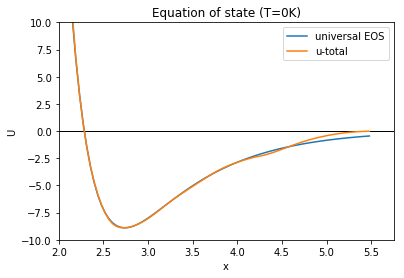

In [1250]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [eos(x) for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
#plt.plot(ene2[:,0], ene2[:,3]/54, label='f-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.ylim(-10,10)
#plt.xlim(2.5, 3.0)
#plt.ylim(-9,-8.8)

plt.xlabel('x')
plt.ylabel(r'U')

In [39]:
rho_a = [1.0]
rho_r = [stats_opt['hyperparams'][-1]]

pair_a = pars_in1[2:]
pair_r = stats_opt['hyperparams']

many_a = [pars_in[0], 0.0, pars_in[1]]

In [40]:
# Ranges of densities and separations

nr = 5000
rcut = stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
#rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 768.0


In [41]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [1340]:
from statmechlib.forcefields import u_core

# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

NameError: name 'rhomax' is not defined

In [708]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lvnew.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))